In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import kagglehub
import joblib
import warnings
warnings.filterwarnings('ignore')

# Download the endometriosis dataset
print("Downloading endometriosis dataset...")
path = kagglehub.dataset_download("michaelanietie/endometriosis-dataset")
print(f"Path to dataset files: {path}")

# Load the CSV file
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
print(f"CSV files found: {csv_files}")

if csv_files:
    dataset_path = os.path.join(path, csv_files[0])
    df = pd.read_csv(dataset_path)
    print(f"\nLoaded dataset: {csv_files[0]}")
else:
    print("No CSV files found in the dataset directory!")

# Display basic information
print(f"\nDataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nData types:")
print(df.dtypes)
print(f"\nMissing values:")
print(df.isnull().sum())
print(f"\nBasic statistics:")
print(df.describe())

C:\Users\icyez\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 207k/207k [00:00<00:00, 254kB/s]

Extracting files...
Path to dataset files: C:\Users\icyez\.cache\kagglehub\datasets\michaelanietie\endometriosis-dataset\versions\1
CSV files found: ['structured_endometriosis_data.csv']

Loaded dataset: structured_endometriosis_data.csv

Dataset shape: (10000, 7)

First few rows:
   Age  Menstrual_Irregularity  Chronic_Pain_Level  Hormone_Level_Abnormality  \
0   24                       1            8.361531                          0   
1   37                       1            4.995508                          0   
2   46                       1            3.363996                          1   
3   32                       1            5.246037                          0   
4   28                       1            3.898932                          1   

   Infertility        BMI  Diagnosis  
0            0  19.451314          0  
1            0  22.388436          0  
2            0  21.320443          0  
3            0  20.177715          1  
4            0  23.538103          1

In [ ]:
## Data Visualization and Interpretation

Let's explore the relationships between variables and the target variable.

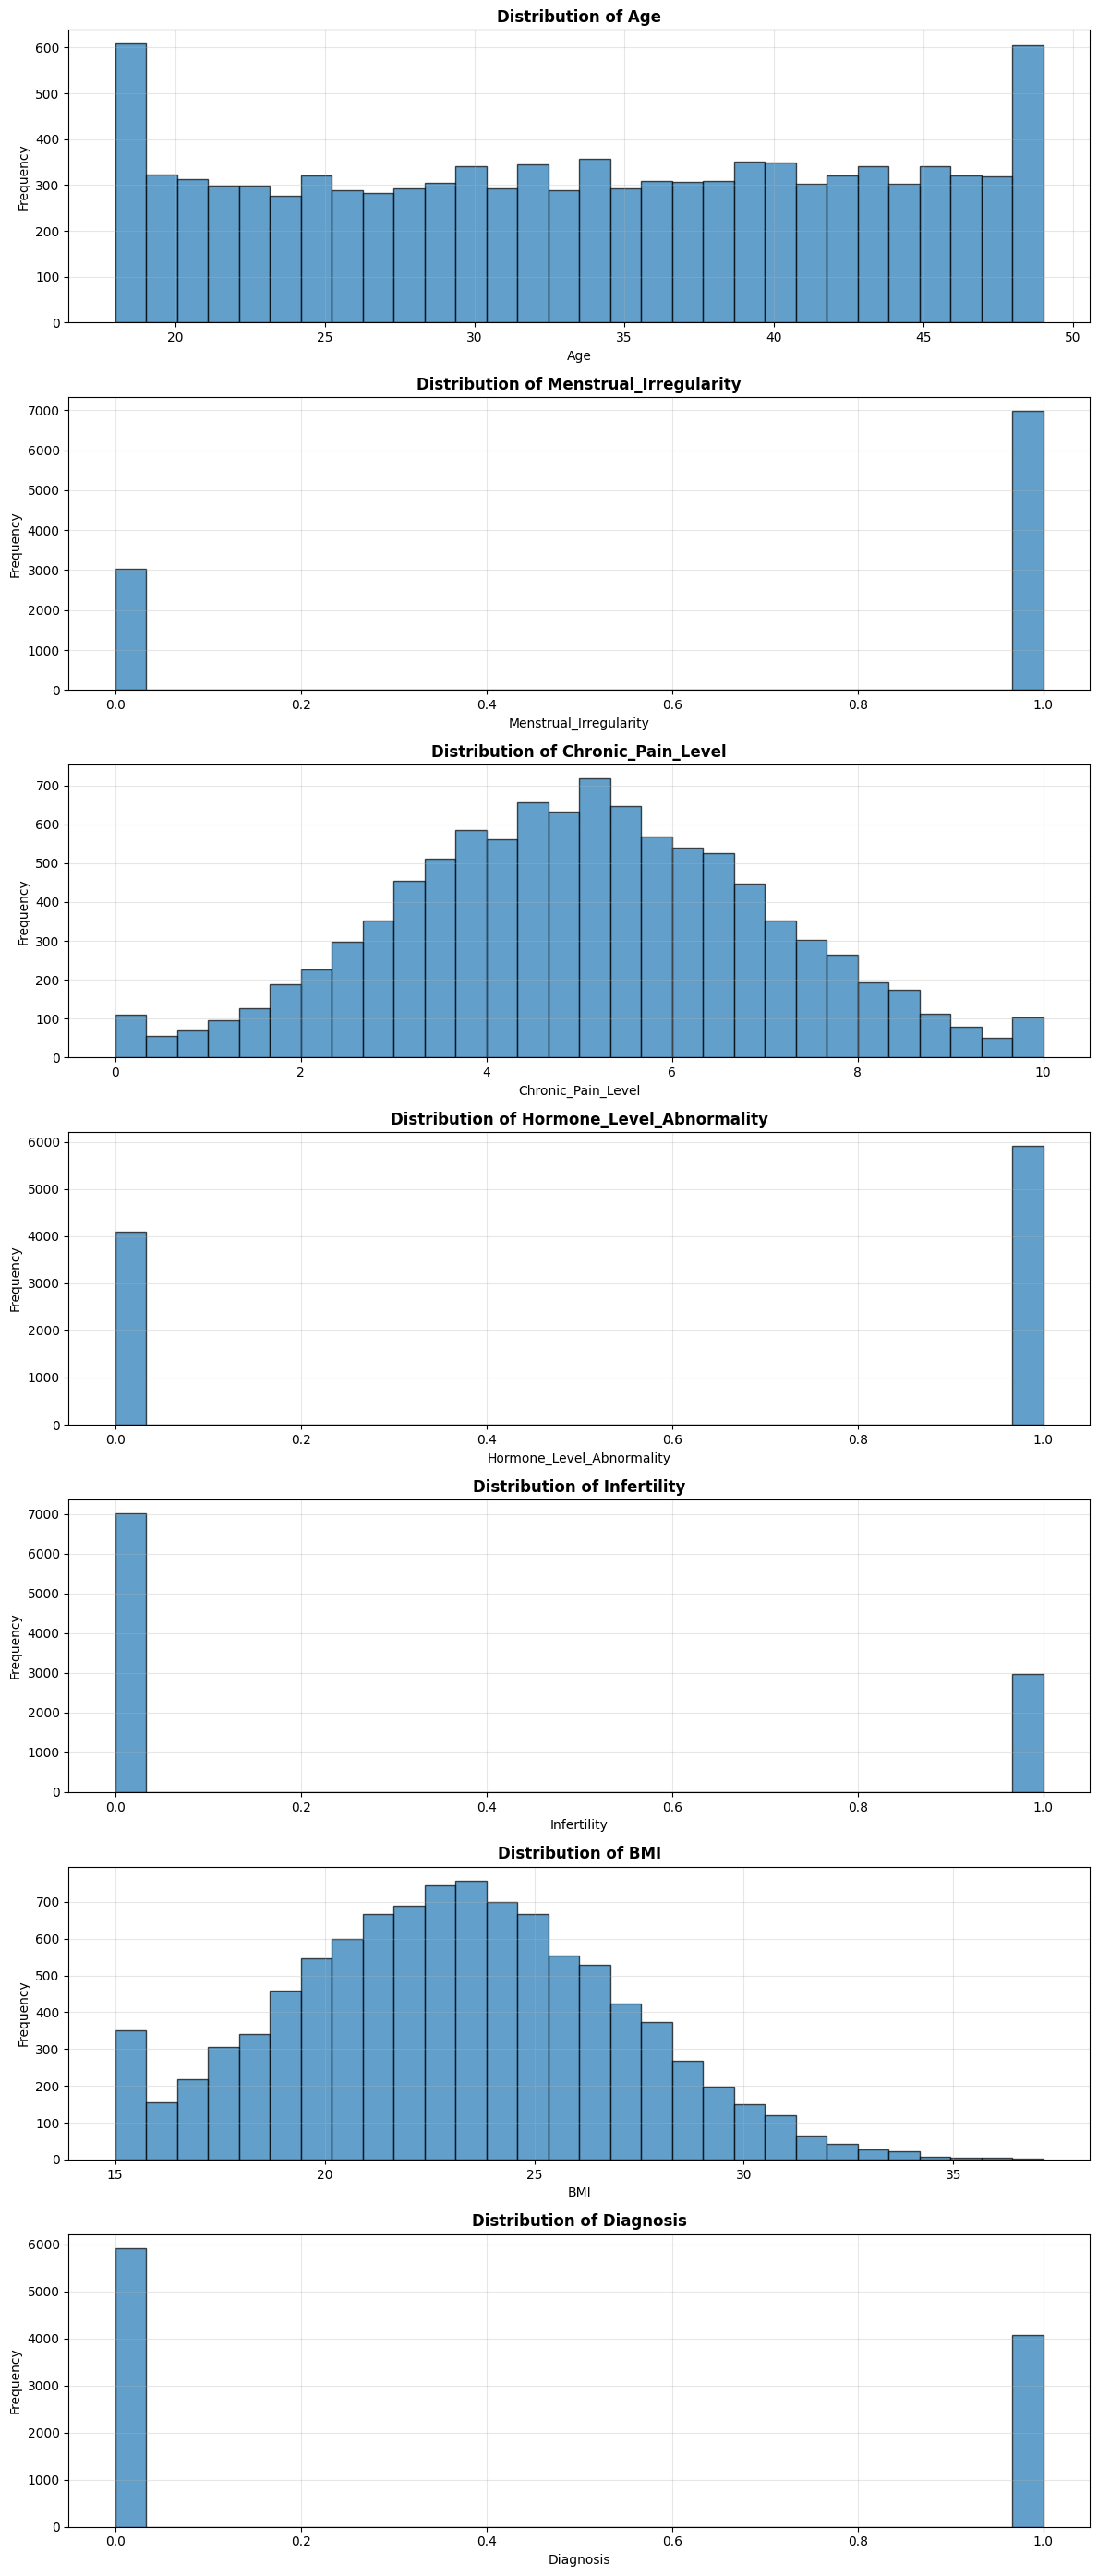

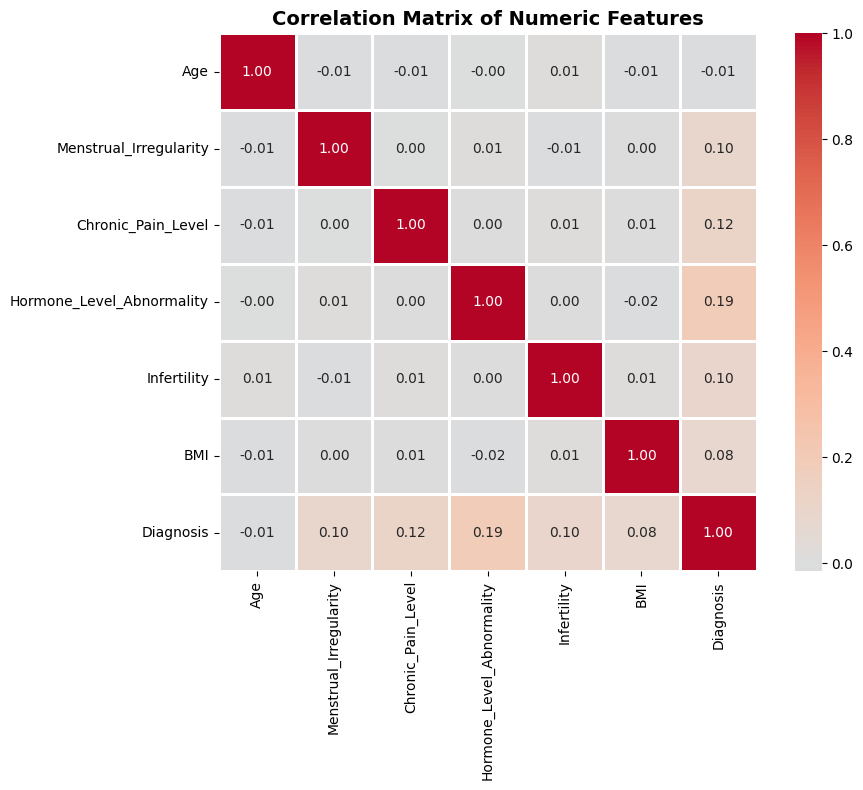

Correlation Matrix:
                                Age  Menstrual_Irregularity  \
Age                        1.000000               -0.007918   
Menstrual_Irregularity    -0.007918                1.000000   
Chronic_Pain_Level        -0.009348                0.000103   
Hormone_Level_Abnormality -0.004070                0.014647   
Infertility                0.014078               -0.012202   
BMI                       -0.011878                0.004868   
Diagnosis                 -0.011559                0.095197   

                           Chronic_Pain_Level  Hormone_Level_Abnormality  \
Age                                 -0.009348                  -0.004070   
Menstrual_Irregularity               0.000103                   0.014647   
Chronic_Pain_Level                   1.000000                   0.002467   
Hormone_Level_Abnormality            0.002467                   1.000000   
Infertility                          0.009299                   0.003890   
BMI                

In [2]:
# Visualize distributions of numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
fig, axes = plt.subplots(len(numeric_cols), 1, figsize=(12, 4*len(numeric_cols)))

if len(numeric_cols) == 1:
    axes = [axes]

for idx, col in enumerate(numeric_cols):
    axes[idx].hist(df[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Correlation heatmap
if len(numeric_cols) > 1:
    plt.figure(figsize=(10, 8))
    correlation_matrix = df[numeric_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                fmt='.2f', square=True, linewidths=1)
    plt.title('Correlation Matrix of Numeric Features', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("Correlation Matrix:")
    print(correlation_matrix)

## Feature Engineering

Now we'll handle missing values, convert categorical variables to numeric, and determine which features are most important.

In [3]:
# Create a copy for preprocessing
df_processed = df.copy()

# Handle missing values
print("Missing values per column:")
print(df_processed.isnull().sum())

# Drop rows with missing target variable (if applicable)
# First, identify the target variable - typically the last numeric column
numeric_cols = df_processed.select_dtypes(include=[np.number]).columns.tolist()
target_col = numeric_cols[-1] if numeric_cols else None

if target_col:
    print(f"\nTarget variable: {target_col}")
    df_processed = df_processed.dropna(subset=[target_col])

# For missing values in features, fill with median for numeric, mode for categorical
for col in df_processed.columns:
    if df_processed[col].isnull().sum() > 0:
        if df_processed[col].dtype in ['float64', 'int64']:
            df_processed[col].fillna(df_processed[col].median(), inplace=True)
        else:
            df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)

print("\nMissing values after imputation:")
print(df_processed.isnull().sum().sum())

# Convert categorical variables to numeric
categorical_cols = df_processed.select_dtypes(include=['object']).columns
label_encoders = {}

print(f"\nCategorical columns to encode: {list(categorical_cols)}")

for col in categorical_cols:
    if col != target_col:  # Don't encode if it's the target
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col].astype(str))
        label_encoders[col] = le
        print(f"Encoded {col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

print("\nProcessed dataset:")
print(df_processed.head())
print(f"\nProcessed data types:")
print(df_processed.dtypes)

Missing values per column:
Age                          0
Menstrual_Irregularity       0
Chronic_Pain_Level           0
Hormone_Level_Abnormality    0
Infertility                  0
BMI                          0
Diagnosis                    0
dtype: int64

Target variable: Diagnosis

Missing values after imputation:
0

Categorical columns to encode: []

Processed dataset:
   Age  Menstrual_Irregularity  Chronic_Pain_Level  Hormone_Level_Abnormality  \
0   24                       1            8.361531                          0   
1   37                       1            4.995508                          0   
2   46                       1            3.363996                          1   
3   32                       1            5.246037                          0   
4   28                       1            3.898932                          1   

   Infertility        BMI  Diagnosis  
0            0  19.451314          0  
1            0  22.388436          0  
2            0  21.3

Feature Importance Analysis:

Correlation with target variable (Diagnosis):
Diagnosis                    1.000000
Hormone_Level_Abnormality    0.187039
Chronic_Pain_Level           0.116996
Infertility                  0.096172
Menstrual_Irregularity       0.095197
BMI                          0.080310
Age                         -0.011559
Name: Diagnosis, dtype: float64


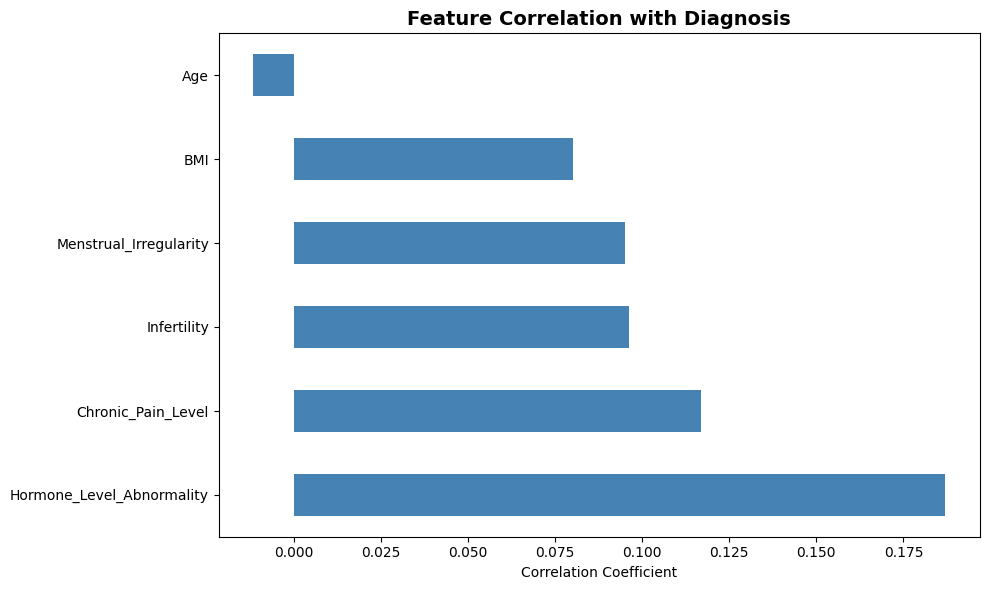


Feature Statistics:
                Age  Menstrual_Irregularity  Chronic_Pain_Level  \
count  10000.000000            10000.000000        10000.000000   
mean      33.692300                0.697500            5.030619   
std        9.205308                0.459364            1.983955   
min       18.000000                0.000000            0.000000   
25%       26.000000                0.000000            3.671697   
50%       34.000000                1.000000            5.035825   
75%       42.000000                1.000000            6.396854   
max       49.000000                1.000000           10.000000   

       Hormone_Level_Abnormality   Infertility           BMI     Diagnosis  
count               10000.000000  10000.000000  10000.000000  10000.000000  
mean                    0.591100      0.298300     23.052865      0.407900  
std                     0.491655      0.457535      3.891615      0.491469  
min                     0.000000      0.000000     15.000000      0

In [4]:
# Feature importance analysis
print("Feature Importance Analysis:")
print("="*50)

# Calculate correlation with target
if target_col:
    correlations = df_processed.corr()[target_col].sort_values(ascending=False)
    print(f"\nCorrelation with target variable ({target_col}):")
    print(correlations)
    
    # Visualize feature correlations
    plt.figure(figsize=(10, 6))
    correlations.drop(target_col).plot(kind='barh', color='steelblue')
    plt.title(f'Feature Correlation with {target_col}', fontsize=14, fontweight='bold')
    plt.xlabel('Correlation Coefficient')
    plt.tight_layout()
    plt.show()

# Drop columns with low variance or high missingness if needed
print("\nFeature Statistics:")
print(df_processed.describe())

## Data Standardization

Standardize all features to have mean=0 and std=1. This is crucial for gradient descent optimization.

In [5]:
# Prepare features and target
X = df_processed.drop(columns=[target_col])
y = df_processed[target_col]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTrain set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nStandardization completed!")
print(f"Training set - Mean: {X_train_scaled.mean(axis=0)[:5]}, Std: {X_train_scaled.std(axis=0)[:5]}")
print(f"Test set - Mean: {X_test_scaled.mean(axis=0)[:5]}, Std: {X_test_scaled.std(axis=0)[:5]}")

Features shape: (10000, 6)
Target shape: (10000,)

Train set size: 8000
Test set size: 2000

Standardization completed!
Training set - Mean: [ 3.55271368e-18  3.24185123e-17 -5.24469357e-16  9.14823772e-17
  1.24344979e-17], Std: [1. 1. 1. 1. 1.]
Test set - Mean: [-0.00585486  0.00136049 -0.01595953 -0.04992893  0.00738167], Std: [0.97837493 0.99941438 0.98344716 1.00848564 1.00323485]


## Model Building: Linear Regression with Gradient Descent

Build a Linear Regression model using SGDRegressor (implements gradient descent).

In [6]:
# 1. Linear Regression with Gradient Descent (SGDRegressor)
print("="*60)
print("1. LINEAR REGRESSION WITH GRADIENT DESCENT (SGDRegressor)")
print("="*60)

# Create and train the model
lr_gd = SGDRegressor(max_iter=1000, random_state=42, loss='squared_error', 
                     learning_rate='optimal', eta0=0.01, verbose=0)

# Store losses for plotting
train_losses = []
test_losses = []

# Train and track losses
for epoch in range(1000):
    lr_gd.partial_fit(X_train_scaled, y_train)
    
    # Calculate MSE on train and test sets
    train_pred = lr_gd.predict(X_train_scaled)
    test_pred = lr_gd.predict(X_test_scaled)
    
    train_loss = mean_squared_error(y_train, train_pred)
    test_loss = mean_squared_error(y_test, test_pred)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)

# Final predictions
y_train_pred_lr = lr_gd.predict(X_train_scaled)
y_test_pred_lr = lr_gd.predict(X_test_scaled)

# Calculate metrics
lr_train_r2 = r2_score(y_train, y_train_pred_lr)
lr_test_r2 = r2_score(y_test, y_test_pred_lr)
lr_train_mse = mean_squared_error(y_train, y_train_pred_lr)
lr_test_mse = mean_squared_error(y_test, y_test_pred_lr)
lr_train_mae = mean_absolute_error(y_train, y_train_pred_lr)
lr_test_mae = mean_absolute_error(y_test, y_test_pred_lr)

print(f"\nLinear Regression (Gradient Descent) Results:")
print(f"  Train R² Score: {lr_train_r2:.4f}")
print(f"  Test R² Score: {lr_test_r2:.4f}")
print(f"  Train MSE: {lr_train_mse:.4f}")
print(f"  Test MSE: {lr_test_mse:.4f}")
print(f"  Train MAE: {lr_train_mae:.4f}")
print(f"  Test MAE: {lr_test_mae:.4f}")

# Store results
results = {
    'Linear Regression (GD)': {
        'model': lr_gd,
        'train_r2': lr_train_r2,
        'test_r2': lr_test_r2,
        'train_mse': lr_train_mse,
        'test_mse': lr_test_mse,
        'y_pred': y_test_pred_lr
    }
}

1. LINEAR REGRESSION WITH GRADIENT DESCENT (SGDRegressor)

Linear Regression (Gradient Descent) Results:
  Train R² Score: 0.0699
  Test R² Score: 0.0692
  Train MSE: 0.2254
  Test MSE: 0.2214
  Train MAE: 0.4492
  Test MAE: 0.4436

Linear Regression (Gradient Descent) Results:
  Train R² Score: 0.0699
  Test R² Score: 0.0692
  Train MSE: 0.2254
  Test MSE: 0.2214
  Train MAE: 0.4492
  Test MAE: 0.4436


## Model Building: Decision Trees

In [7]:
# 2. Decision Tree Regressor
print("\n" + "="*60)
print("2. DECISION TREE REGRESSOR")
print("="*60)

dt_model = DecisionTreeRegressor(random_state=42, max_depth=10, min_samples_split=5, 
                                 min_samples_leaf=2)
dt_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_dt = dt_model.predict(X_train_scaled)
y_test_pred_dt = dt_model.predict(X_test_scaled)

# Calculate metrics
dt_train_r2 = r2_score(y_train, y_train_pred_dt)
dt_test_r2 = r2_score(y_test, y_test_pred_dt)
dt_train_mse = mean_squared_error(y_train, y_train_pred_dt)
dt_test_mse = mean_squared_error(y_test, y_test_pred_dt)
dt_train_mae = mean_absolute_error(y_train, y_train_pred_dt)
dt_test_mae = mean_absolute_error(y_test, y_test_pred_dt)

print(f"\nDecision Tree Results:")
print(f"  Train R² Score: {dt_train_r2:.4f}")
print(f"  Test R² Score: {dt_test_r2:.4f}")
print(f"  Train MSE: {dt_train_mse:.4f}")
print(f"  Test MSE: {dt_test_mse:.4f}")
print(f"  Train MAE: {dt_train_mae:.4f}")
print(f"  Test MAE: {dt_test_mae:.4f}")

# Feature importance
feature_importance_dt = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"\nTop 10 Important Features (Decision Tree):")
print(feature_importance_dt.head(10))

# Store results
results['Decision Tree'] = {
    'model': dt_model,
    'train_r2': dt_train_r2,
    'test_r2': dt_test_r2,
    'train_mse': dt_train_mse,
    'test_mse': dt_test_mse,
    'y_pred': y_test_pred_dt
}


2. DECISION TREE REGRESSOR

Decision Tree Results:
  Train R² Score: 0.2606
  Test R² Score: -0.1065
  Train MSE: 0.1792
  Test MSE: 0.2632
  Train MAE: 0.3583
  Test MAE: 0.4412

Top 10 Important Features (Decision Tree):
                     Feature  Importance
2         Chronic_Pain_Level    0.394802
5                        BMI    0.271528
0                        Age    0.127998
3  Hormone_Level_Abnormality    0.126443
4                Infertility    0.044087
1     Menstrual_Irregularity    0.035142


## Model Building: Random Forest

In [8]:
# 3. Random Forest Regressor
print("\n" + "="*60)
print("3. RANDOM FOREST REGRESSOR")
print("="*60)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10, 
                                 min_samples_split=5, min_samples_leaf=2, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_rf = rf_model.predict(X_train_scaled)
y_test_pred_rf = rf_model.predict(X_test_scaled)

# Calculate metrics
rf_train_r2 = r2_score(y_train, y_train_pred_rf)
rf_test_r2 = r2_score(y_test, y_test_pred_rf)
rf_train_mse = mean_squared_error(y_train, y_train_pred_rf)
rf_test_mse = mean_squared_error(y_test, y_test_pred_rf)
rf_train_mae = mean_absolute_error(y_train, y_train_pred_rf)
rf_test_mae = mean_absolute_error(y_test, y_test_pred_rf)

print(f"\nRandom Forest Results:")
print(f"  Train R² Score: {rf_train_r2:.4f}")
print(f"  Test R² Score: {rf_test_r2:.4f}")
print(f"  Train MSE: {rf_train_mse:.4f}")
print(f"  Test MSE: {rf_test_mse:.4f}")
print(f"  Train MAE: {rf_train_mae:.4f}")
print(f"  Test MAE: {rf_test_mae:.4f}")

# Feature importance
feature_importance_rf = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"\nTop 10 Important Features (Random Forest):")
print(feature_importance_rf.head(10))

# Store results
results['Random Forest'] = {
    'model': rf_model,
    'train_r2': rf_train_r2,
    'test_r2': rf_test_r2,
    'train_mse': rf_train_mse,
    'test_mse': rf_test_mse,
    'y_pred': y_test_pred_rf
}


3. RANDOM FOREST REGRESSOR

Random Forest Results:
  Train R² Score: 0.3258
  Test R² Score: 0.0413
  Train MSE: 0.1634
  Test MSE: 0.2281
  Train MAE: 0.3763
  Test MAE: 0.4438

Top 10 Important Features (Random Forest):
                     Feature  Importance
2         Chronic_Pain_Level    0.344929
5                        BMI    0.321808
0                        Age    0.162087
3  Hormone_Level_Abnormality    0.096447
4                Infertility    0.039536
1     Menstrual_Irregularity    0.035193

Random Forest Results:
  Train R² Score: 0.3258
  Test R² Score: 0.0413
  Train MSE: 0.1634
  Test MSE: 0.2281
  Train MAE: 0.3763
  Test MAE: 0.4438

Top 10 Important Features (Random Forest):
                     Feature  Importance
2         Chronic_Pain_Level    0.344929
5                        BMI    0.321808
0                        Age    0.162087
3  Hormone_Level_Abnormality    0.096447
4                Infertility    0.039536
1     Menstrual_Irregularity    0.035193


## Model Comparison and Best Model Selection


MODEL COMPARISON SUMMARY
                 Model  Train R²   Test R²  Train MSE  Test MSE
Linear Regression (GD)  0.069871  0.069201   0.225391  0.221437
         Decision Tree  0.260624 -0.106519   0.179167  0.263241
         Random Forest  0.325799  0.041336   0.163374  0.228066

BEST MODEL: Linear Regression (GD)
Test R² Score: 0.0692
Test MSE: 0.2214


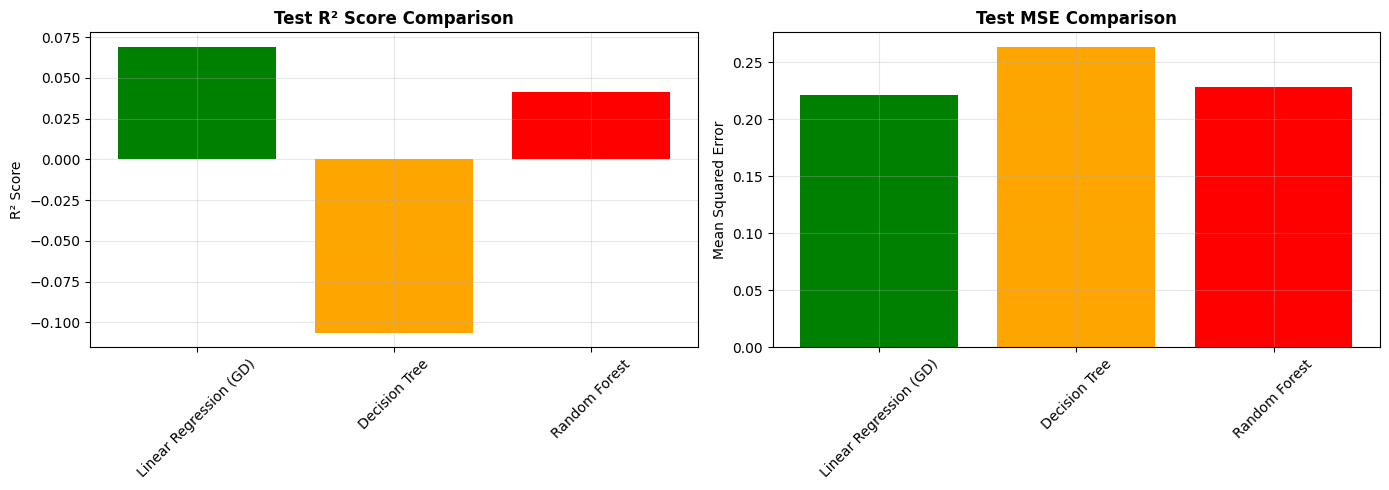

In [9]:
# Compare all models
print("\n" + "="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train R²': [results[m]['train_r2'] for m in results.keys()],
    'Test R²': [results[m]['test_r2'] for m in results.keys()],
    'Train MSE': [results[m]['train_mse'] for m in results.keys()],
    'Test MSE': [results[m]['test_mse'] for m in results.keys()]
})

print(comparison_df.to_string(index=False))

# Select best model based on test R² score
best_model_name = comparison_df.loc[comparison_df['Test R²'].idxmax(), 'Model']
best_model_info = results[best_model_name]
best_model = best_model_info['model']

print(f"\n{'='*60}")
print(f"BEST MODEL: {best_model_name}")
print(f"Test R² Score: {best_model_info['test_r2']:.4f}")
print(f"Test MSE: {best_model_info['test_mse']:.4f}")
print(f"{'='*60}")

# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Test R² comparison
axes[0].bar(comparison_df['Model'], comparison_df['Test R²'], color=['green', 'orange', 'red'])
axes[0].set_title('Test R² Score Comparison', fontsize=12, fontweight='bold')
axes[0].set_ylabel('R² Score')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(alpha=0.3)

# Test MSE comparison
axes[1].bar(comparison_df['Model'], comparison_df['Test MSE'], color=['green', 'orange', 'red'])
axes[1].set_title('Test MSE Comparison', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Mean Squared Error')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Loss Curves and Predictions Visualization

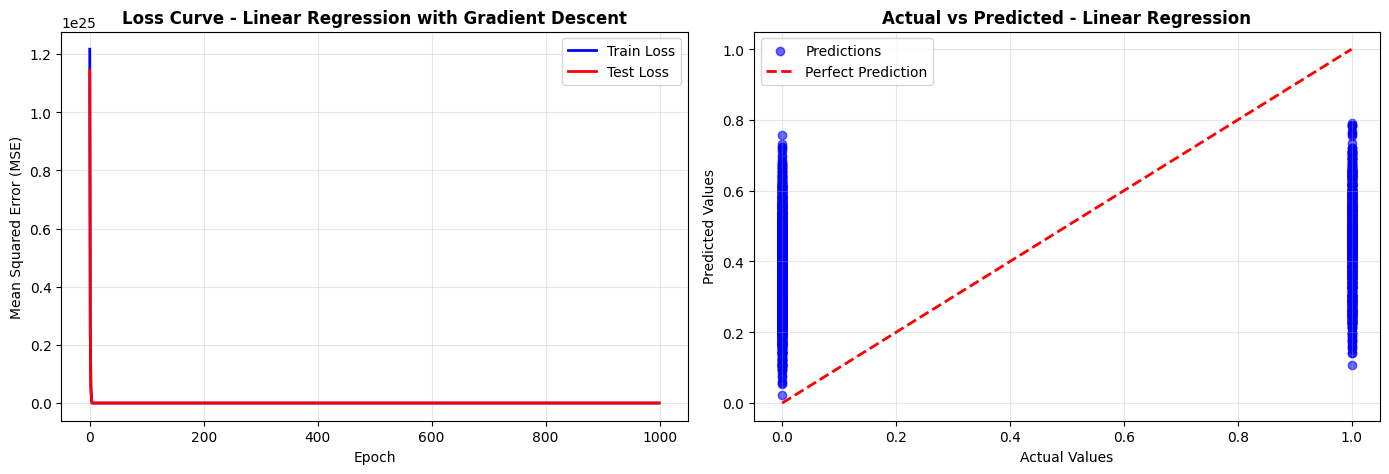

Linear Regression - Gradient Descent Loss:
  Final Train Loss: 0.2254
  Final Test Loss: 0.2214


In [10]:
# Plot loss curves for Linear Regression (Gradient Descent)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curve
axes[0].plot(train_losses, label='Train Loss', linewidth=2, color='blue')
axes[0].plot(test_losses, label='Test Loss', linewidth=2, color='red')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Mean Squared Error (MSE)')
axes[0].set_title('Loss Curve - Linear Regression with Gradient Descent', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Actual vs Predicted for Linear Regression
axes[1].scatter(y_test, y_test_pred_lr, alpha=0.6, color='blue', label='Predictions')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Values')
axes[1].set_ylabel('Predicted Values')
axes[1].set_title('Actual vs Predicted - Linear Regression', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Linear Regression - Gradient Descent Loss:")
print(f"  Final Train Loss: {train_losses[-1]:.4f}")
print(f"  Final Test Loss: {test_losses[-1]:.4f}")

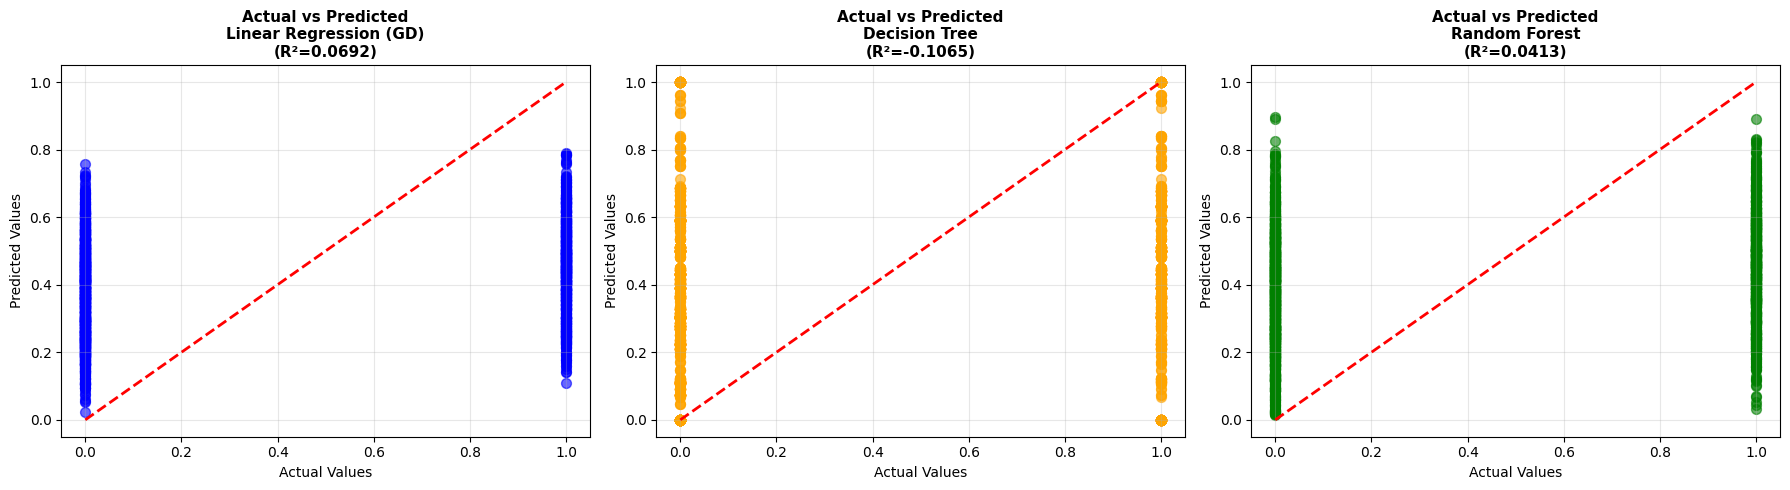

In [11]:
# Visualize predictions for all three models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_to_plot = ['Linear Regression (GD)', 'Decision Tree', 'Random Forest']
predictions = [results[m]['y_pred'] for m in models_to_plot]
colors = ['blue', 'orange', 'green']

for idx, (model_name, y_pred, color) in enumerate(zip(models_to_plot, predictions, colors)):
    axes[idx].scatter(y_test, y_pred, alpha=0.6, color=color, s=50)
    axes[idx].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[idx].set_xlabel('Actual Values')
    axes[idx].set_ylabel('Predicted Values')
    axes[idx].set_title(f'Actual vs Predicted\n{model_name}\n(R²={results[model_name]["test_r2"]:.4f})', 
                        fontsize=11, fontweight='bold')
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Single Data Point Prediction Example

In [ ]:
# Make a prediction on a single data point from the test set
print("="*60)
print("SINGLE DATA POINT PREDICTION")
print("="*60)

# Select the first row from the test set
single_sample_index = 0
single_sample = X_test_scaled[single_sample_index:single_sample_index+1]
single_sample_original = X_test.iloc[single_sample_index]
actual_value = y_test.iloc[single_sample_index]

print(f"\nTest Sample #{single_sample_index + 1}:")
print("-" * 60)
print("\nInput Features:")
for feature, value in single_sample_original.items():
    print(f"  {feature}: {value}")

print(f"\nActual Target Value: {actual_value:.4f}")
print("\nPredictions from all models:")
print("-" * 60)

# Make predictions with all three models
for model_name, model_info in results.items():
    model = model_info['model']
    prediction = model.predict(single_sample)[0]
    error = abs(prediction - actual_value)
    print(f"\n{model_name}:")
    print(f"  Predicted: {prediction:.4f}")
    print(f"  Error: {error:.4f}")

# Use the best model for the final prediction
best_prediction = best_model.predict(single_sample)[0]
print(f"\n{'='*60}")
print(f"Best Model ({best_model_name}) Prediction: {best_prediction:.4f}")
print(f"Actual Value: {actual_value:.4f}")
print(f"Absolute Error: {abs(best_prediction - actual_value):.4f}")
print(f"{'='*60}")

## Linear Regression Line Visualization

In [ ]:
# Visualize the Linear Regression fit line on the dataset
# For multivariate regression, we'll plot actual vs predicted with the regression line
print("="*60)
print("LINEAR REGRESSION FIT VISUALIZATION")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Training data with fit line
axes[0].scatter(y_train, y_train_pred_lr, alpha=0.5, s=30, color='blue', label='Training Data')
# Plot the perfect fit line (identity line)
min_val = min(y_train.min(), y_train_pred_lr.min())
max_val = max(y_train.max(), y_train_pred_lr.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Fit Line')
# Add regression line (fitted values)
sorted_idx = np.argsort(y_train)
axes[0].plot(y_train.iloc[sorted_idx], y_train_pred_lr[sorted_idx], 'g-', linewidth=2, alpha=0.7, label='Regression Line')
axes[0].set_xlabel('Actual Values', fontsize=12)
axes[0].set_ylabel('Predicted Values', fontsize=12)
axes[0].set_title(f'Linear Regression Fit - Training Set\n(R² = {lr_train_r2:.4f})', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Right plot: Test data with fit line
axes[1].scatter(y_test, y_test_pred_lr, alpha=0.5, s=30, color='orange', label='Test Data')
min_val = min(y_test.min(), y_test_pred_lr.min())
max_val = max(y_test.max(), y_test_pred_lr.max())
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Fit Line')
# Add regression line (fitted values)
sorted_idx = np.argsort(y_test)
axes[1].plot(y_test.iloc[sorted_idx], y_test_pred_lr[sorted_idx], 'g-', linewidth=2, alpha=0.7, label='Regression Line')
axes[1].set_xlabel('Actual Values', fontsize=12)
axes[1].set_ylabel('Predicted Values', fontsize=12)
axes[1].set_title(f'Linear Regression Fit - Test Set\n(R² = {lr_test_r2:.4f})', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nThe green line shows the fitted regression line")
print(f"The red dashed line represents perfect predictions (y = x)")
print(f"Points closer to the red line indicate better predictions")

## Save Best Model and Create Prediction Script

In [12]:
# Save the best model and the scaler for later use
import os

# Create models directory if it doesn't exist
models_dir = 'models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Save the best model
best_model_path = os.path.join(models_dir, 'best_model.pkl')
joblib.dump(best_model, best_model_path)
print(f"Best model saved to: {best_model_path}")

# Save the scaler
scaler_path = os.path.join(models_dir, 'scaler.pkl')
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to: {scaler_path}")

# Save feature names
features_path = os.path.join(models_dir, 'features.pkl')
joblib.dump(X.columns.tolist(), features_path)
print(f"Feature names saved to: {features_path}")

# Save label encoders for categorical variables
encoders_path = os.path.join(models_dir, 'label_encoders.pkl')
joblib.dump(label_encoders, encoders_path)
print(f"Label encoders saved to: {encoders_path}")

# Save a summary of the best model
summary = f"""
BEST MODEL SUMMARY
==================
Model Name: {best_model_name}
Test R² Score: {best_model_info['test_r2']:.4f}
Test MSE: {best_model_info['test_mse']:.4f}
Train R² Score: {best_model_info['train_r2']:.4f}
Train MSE: {best_model_info['train_mse']:.4f}

Dataset Information:
- Total samples: {len(df_processed)}
- Training samples: {len(X_train)}
- Testing samples: {len(X_test)}
- Number of features: {X.shape[1]}
- Target variable: {target_col}

Model Path: {best_model_path}
Scaler Path: {scaler_path}
Features Path: {features_path}
Label Encoders Path: {encoders_path}
"""

summary_path = os.path.join(models_dir, 'model_summary.txt')
with open(summary_path, 'w') as f:
    f.write(summary)

print(f"\nModel summary saved to: {summary_path}")
print(summary)

Best model saved to: models\best_model.pkl
Scaler saved to: models\scaler.pkl
Feature names saved to: models\features.pkl
Label encoders saved to: models\label_encoders.pkl

Model summary saved to: models\model_summary.txt

BEST MODEL SUMMARY
Model Name: Linear Regression (GD)
Test R² Score: 0.0692
Test MSE: 0.2214
Train R² Score: 0.0699
Train MSE: 0.2254

Dataset Information:
- Total samples: 10000
- Training samples: 8000
- Testing samples: 2000
- Number of features: 6
- Target variable: Diagnosis

Model Path: models\best_model.pkl
Scaler Path: models\scaler.pkl
Features Path: models\features.pkl
Label Encoders Path: models\label_encoders.pkl

